<a href="https://colab.research.google.com/github/EdwardFang09/IEE4912/blob/main/Whisper_benchmark_v3_(documentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Benchmark (no early stopping)

Suara direkam di lab ramai untuk simulasi.

In [1]:
#Library for quick-start on google colab
!pip install faster-whisper jiwer nvidia-ml-py3

In [2]:
import time
from faster_whisper import WhisperModel, BatchedInferencePipeline
import pandas as pd
import jiwer
import nvidia_smi
from jiwer import transforms
import os
import torch

# Define audio files and their ground truth transcripts (dictionary)
audio_ground_truth = {
    "edwardmentimeter.mp3": "sora, open mentimeter.",
    #... more audio files and transcripts
}

# Model sizes and compute types to benchmark
model_configs = [
    {"size": "turbo", "compute": "float16"},
    {"size": "turbo", "compute": "float32"},
    {"size": "turbo", "compute": "int8"},
    {"size": "turbo", "compute": "int8_float16"},
    {"size": "tiny", "compute": "float32"},
    {"size": "tiny", "compute": "float16"},
    {"size": "tiny", "compute": "int8"},  # CPU INT8
    {"size": "tiny", "compute": "int8_float16"},  #
    {"size": "base", "compute": "float32"},
    {"size": "base", "compute": "float16"},
    {"size": "base", "compute": "int8"},  # CPU INT8
    {"size": "base", "compute": "int8_float16"},  # CPU INT8
    {"size": "small", "compute": "float32"},
    {"size": "small", "compute": "float16"},
    {"size": "small", "compute": "int8"},  # CPU INT8
    {"size": "small", "compute": "int8_float16"},  # CPU INT8
    {"size": "medium", "compute": "float32"},
    {"size": "medium", "compute": "float16"},
    {"size": "medium", "compute": "int8"},  # CPU INT8
    {"size": "medium", "compute": "int8_float16"},  # CPU INT8
    {"size": "large-v2", "compute": "float32"},
    {"size": "large-v2", "compute": "float16"},
    {"size": "large-v2", "compute": "int8"},  # CPU INT8
    {"size": "large-v2", "compute": "int8_float16"},  # CPU INT8
    {"size": "large-v3", "compute": "float32"},
    {"size": "large-v3", "compute": "float16"},
    {"size": "large-v3", "compute": "int8"},
    {"size": "large-v3", "compute": "int8_float16"},
]

results = []

print(f"CUDA available: {torch.cuda.is_available()}")

for audio_file, ground_truth_transcript in audio_ground_truth.items():
    for config in model_configs:
        start_time = time.time()

        try:
            device = "cuda" if config["compute"]!= "int8" else "cpu"

            if device == "cuda":
                nvidia_smi.nvmlInit()
                handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
                # No memory info printed here

            model = WhisperModel(config["size"], device=device, compute_type=config["compute"])

            if config["size"] == "turbo":
                batched_model = BatchedInferencePipeline(model=model)
                segments, info = batched_model.transcribe(audio_file, language='en')
            else:
                segments, info = model.transcribe(audio_file, beam_size=5, language='en')

            segments_list = list(segments)

            transform = transforms.Compose([
                transforms.ToLowerCase(),
                transforms.RemovePunctuation(),
                transforms.RemoveMultipleSpaces(),
                transforms.Strip(),
            ])

            ground_truth_transformed = transform(ground_truth_transcript)
            predicted_transcript = " ".join([segment.text for segment in segments_list])
            predicted_transcript_transformed = transform(predicted_transcript)

            wer = jiwer.wer(ground_truth_transformed, predicted_transcript_transformed)

            end_time = time.time()
            inference_time = end_time - start_time

            if device == "cuda":
                infoo = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

            results.append({
                "audio_file": audio_file,
                "model_size": config["size"],
                "compute_type": config["compute"],
                "inference_time": inference_time,
                "wer": wer,
                "predicted_transcript": predicted_transcript,
                "Used memory (GB)": infoo.used / (1024 ** 3)
            })

            print(
                f"Audio: {audio_file}, Model: {config['size']}, Compute: {config['compute']}, Time: {inference_time:.2f}s, WER: {wer:.2f}, Text:, {predicted_transcript}, Used memory (GB): {infoo.used / (1024 ** 3)}"
            )

        except Exception as e:
            print(
                f"Error with Audio: {audio_file}, Model: {config['size']}, Compute: {config['compute']}: {e}"
            )
            results.append({
                "audio_file": audio_file,
                "model_size": config["size"],
                "compute_type": config["compute"],
                "inference_time": "Error",
                "error": str(e),
                "wer": "Error",
                "predicted_transcript": "Error",
            })

        finally:
            del model
            if config["size"] == "turbo":
                del batched_model
            torch.cuda.empty_cache()

# Print or save results (e.g., to a CSV file)
df = pd.DataFrame(results)
df.to_csv("whisper_benchmark_results.csv", index=False)
print(df)

CUDA available: True


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Audio: edwardmentimeter.mp3, Model: turbo, Compute: float16, Time: 15.65s, WER: 0.00, Text:,  Sora open mentimeter., Used memory (GB): 2.0623779296875
Audio: edwardmentimeter.mp3, Model: turbo, Compute: float32, Time: 6.27s, WER: 0.00, Text:,  Sora open mentimeter., Used memory (GB): 3.4686279296875
Audio: edwardmentimeter.mp3, Model: turbo, Compute: int8, Time: 35.19s, WER: 0.00, Text:,  Sora open mentimeter., Used memory (GB): 3.4686279296875
Audio: edwardmentimeter.mp3, Model: turbo, Compute: int8_float16, Time: 3.90s, WER: 0.00, Text:,  Sora Open Mentimeter., Used memory (GB): 1.2186279296875
Audio: edwardmentimeter.mp3, Model: tiny, Compute: float32, Time: 1.30s, WER: 1.00, Text:,  Soura Oparenti Matter, Used memory (GB): 0.5623779296875
Audio: edwardmentimeter.mp3, Model: tiny, Compute: float16, Time: 0.83s, WER: 1.00, Text:,  Soura Oparenti Matter, Used memory (GB): 0.5643310546875
Audio: edwardmentimeter.mp3, Model: tiny, Compute: int8, Time: 4.02s, WER: 0.67, Text:,  SORA OPER

Kesimpulan: tidak perlu model besar. Model small bahkan sudah cukup untuk akurasi 100% dengan pemakaian memori ~1GB juga dengan waktu proses <2 detik

Kesimpulan: turbo tidak digunakan karena memakan memori >2GB, yaitu melebihi kapasitas jetson nano 2GB

<h1 >Trained benchmark

In [3]:
!pip install transformers torch jiwer datasets bitsandbytes #(-u)

In [4]:
#!pip install --force-reinstall torchvision (only if needed if bug)

In [5]:
import time
import torch
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    BitsAndBytesConfig,
)
from datasets import load_dataset
import jiwer
from jiwer import transforms
import librosa
import numpy as np
import nvidia_smi

# Load the processor
processor = WhisperProcessor.from_pretrained("EdwardFang09/whisper-base-TA-2025_v2")

# Load your audio data and ground truth transcripts
audio_ground_truth = {
    "edwardmentimeter.mp3": "sora, open mentimeter.",
    # ... more audio files and transcripts
}

# Benchmark configurations
compute_types = ["float32", "float16", "int8_float16", "int8"]

results = []

for compute_type in compute_types:
    # Load model with specified compute type
    if compute_type == "float16":
        model = WhisperForConditionalGeneration.from_pretrained(
            "EdwardFang09/whisper-base-TA-2025_v2", torch_dtype=torch.float16
        ).to("cuda")
        # Cast all model parameters to float16
        for name, param in model.named_parameters():
            param.data = param.data.type(torch.float16)
    elif compute_type == "int8_float16":
        # Use BitsAndBytesConfig for int8 quantization with mixed precision
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,  # Load in int8
            llm_int8_threshold=6.0,  # Adjust threshold if needed
        )
        model = WhisperForConditionalGeneration.from_pretrained(
            "EdwardFang09/whisper-base-TA-2025_v2",
            quantization_config=quantization_config,
        )
    elif compute_type == "int8":
        # Use BitsAndBytesConfig for pure int8 quantization
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,  # Load in int8
            llm_int8_threshold=6.0,  # Adjust threshold if needed
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )
        model = WhisperForConditionalGeneration.from_pretrained(
            "EdwardFang09/whisper-base-TA-2025_v2",
            quantization_config=quantization_config,
        )

        # Get the bias type
        for name, module in model.named_modules():
            if hasattr(module, "bias") and module.bias is not None:
                bias_dtype = module.bias.dtype
                break  # Assuming all biases have the same dtype

    else:  # Default to float32
        model = WhisperForConditionalGeneration.from_pretrained(
            "EdwardFang09/whisper-base-TA-2025_v2"
        ).to("cuda")

    for audio_file, ground_truth_transcript in audio_ground_truth.items():
        start_time = time.time()

        try:
            # Load audio data using librosa
            audio_data, sr = librosa.load(audio_file, sr=16000)

            # Use the audio data as input to the processor
            input_features = processor(
                audio_data, sampling_rate=sr, return_tensors="pt"
            ).input_features

            # Cast input_features if necessary
            if compute_type in ["int8_float16", "float16"]:
                input_features = input_features.type(torch.float16)
            elif compute_type == "int8":
                input_features = input_features.type(bias_dtype)  # Cast to match bias type

            # Move input_features to CUDA after type casting
            input_features = input_features.to("cuda")

            # Generate predictions
            predicted_ids = model.generate(input_features)
            predicted_transcript = processor.batch_decode(
                predicted_ids, skip_special_tokens=True
            )[0]

            # Calculate WER
            transform = transforms.Compose(
                [
                    transforms.ToLowerCase(),
                    transforms.RemovePunctuation(),
                    transforms.RemoveMultipleSpaces(),
                    transforms.Strip(),
                ]
            )
            ground_truth_transformed = transform(ground_truth_transcript)
            predicted_transcript_transformed = transform(predicted_transcript)
            wer = jiwer.wer(ground_truth_transformed, predicted_transcript_transformed)

            end_time = time.time()
            inference_time = end_time - start_time

            # Get Memory Usage
            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            infoo = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

            results.append(
                {
                    "audio_file": audio_file,
                    "model_size": "trained",
                    "compute_type": compute_type,
                    "inference_time": inference_time,
                    "wer": wer,
                    "predicted_transcript": predicted_transcript,
                    "Used memory (GB)": infoo.used / (1024**3),
                }
            )

            print(
                f"Audio: {audio_file}, Model: trained, Compute Type: {compute_type}, Time: {inference_time:.2f}s, WER: {wer:.2f}, Text: {predicted_transcript}, Used memory (GB): {infoo.used / (1024 ** 3)}"
            )

        except Exception as e:
            print(f"Error with Audio: {audio_file}: {e}")
            results.append(
                {
                    "audio_file": audio_file,
                    "model_size": "trained",
                    "compute_type": compute_type,
                    "inference_time": "Error",
                    "error": str(e),
                    "wer": "Error",
                    "predicted_transcript": "Error",
                    "Used memory (GB)": "Error",
                }
            )

    del model  # Release memory after each compute type
    torch.cuda.empty_cache()

# Save or print the results
import pandas as pd

df = pd.DataFrame(results)
df.to_csv("huggingface_whisper_benchmark_trained_with_compute_types.csv", index=False)
print(df)

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Audio: edwardmentimeter.mp3, Model: trained, Compute Type: float32, Time: 5.08s, WER: 0.00, Text: sora open mentimeter, Used memory (GB): 0.7303466796875
Audio: edwardmentimeter.mp3, Model: trained, Compute Type: float16, Time: 0.22s, WER: 0.00, Text: sora open mentimeter, Used memory (GB): 0.7010498046875


`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Audio: edwardmentimeter.mp3, Model: trained, Compute Type: int8_float16, Time: 0.29s, WER: 0.00, Text: sora open mentimeter, Used memory (GB): 0.6072998046875
Audio: edwardmentimeter.mp3, Model: trained, Compute Type: int8, Time: 0.24s, WER: 0.00, Text: sora open mentimeter, Used memory (GB): 0.6072998046875
             audio_file model_size  compute_type  inference_time  wer  \
0  edwardmentimeter.mp3    trained       float32        5.077335  0.0   
1  edwardmentimeter.mp3    trained       float16        0.217763  0.0   
2  edwardmentimeter.mp3    trained  int8_float16        0.286192  0.0   
3  edwardmentimeter.mp3    trained          int8        0.236037  0.0   

   predicted_transcript  Used memory (GB)  
0  sora open mentimeter          0.730347  
1  sora open mentimeter          0.701050  
2  sora open mentimeter          0.607300  
3  sora open mentimeter          0.607300  


Push to huggingface

In [6]:
!pip install huggingface_hub

In [7]:
from huggingface_hub import HfApi, HfFolder

# Read the token from token.txt
with open("token.txt", "r") as f:
    token = f.readline().strip()  # Read the first line and remove whitespace

# Save the token using HfFolder
HfFolder.save_token(token) # my secret token

# Create an instance of the HfApi
api = HfApi()

# Define the repository ID
repo_id = "EdwardFang09/IEE4912-benchmark-result"  # Replace with your desired repository name

# Create the repository
api.create_repo(
    repo_id=repo_id,
    repo_type="dataset",  # Specify the repository type
    private=False,  # Set to True if you want a private repository
    exist_ok=True, # If you are not sure if the repo exists, change this to True. It will not create one if the repo exists.
)

print(f"Dataset repository '{repo_id}' created successfully!")

Dataset repository 'EdwardFang09/IEE4912-benchmark-result' created successfully!


In [8]:
from huggingface_hub import HfApi, HfFolder
import pandas as pd

# Read the token from token.txt
with open("token.txt", "r") as f:
    token = f.readline().strip()  # Read the first line and remove whitespace

# Save the token using HfFolder
HfFolder.save_token(token) # my secret token

# Create an instance of the HfApi
api = HfApi()

# Define the repository ID
repo_id = "EdwardFang09/IEE4912-benchmark-result"  # Replace with your repository name

# Define the CSV file paths
csv_files = [
    "whisper_benchmark_results.csv",
    "huggingface_whisper_benchmark_trained_with_compute_types.csv"
]

# Upload each CSV file
for csv_file in csv_files:
    df = pd.read_csv(csv_file)  # Load the CSV into a pandas DataFrame
    api.upload_file(
        path_or_fileobj=csv_file,
        path_in_repo=csv_file,  # Use the same filename in the repository
        repo_id=repo_id,
        repo_type="dataset",  # Assuming you're uploading to a dataset repository
    )
    print(f"Uploaded {csv_file} to {repo_id}")

print("All CSV files uploaded successfully!")

Uploaded whisper_benchmark_results.csv to EdwardFang09/IEE4912-benchmark-result
Uploaded huggingface_whisper_benchmark_trained_with_compute_types.csv to EdwardFang09/IEE4912-benchmark-result
All CSV files uploaded successfully!


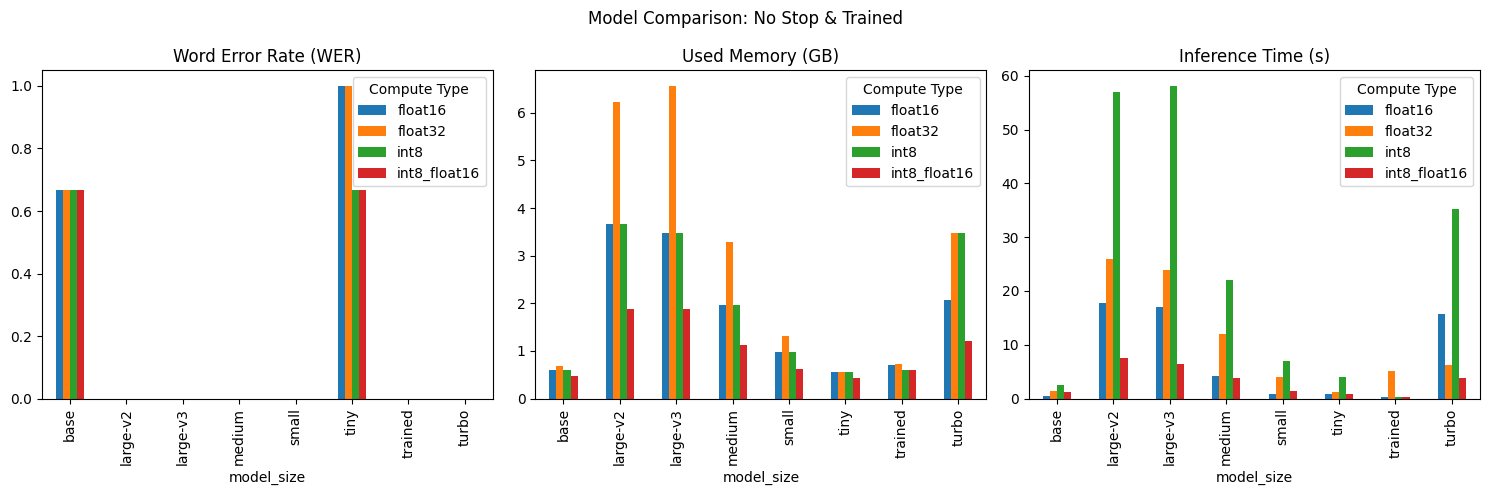

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV files
df_no_stop = pd.read_csv("whisper_benchmark_results.csv") # jangan pakai ini
df_trained = pd.read_csv("huggingface_whisper_benchmark_trained_with_compute_types.csv")

# Add a compute_type column to df_trained
# df_trained['compute_type'] = 'trained'

# Merge dataframes for easier plotting
df_combined = pd.concat([df_no_stop, df_trained], ignore_index=True)

# Group by model size and compute type to get average results
df_grouped = df_combined.groupby(["model_size", "compute_type"])[
    ["wer", "Used memory (GB)", "inference_time"]
].mean().reset_index()

# Reshape the data for plotting
df_pivot = df_grouped.pivot(index='model_size', columns='compute_type', values=['wer', 'Used memory (GB)', 'inference_time'])

# Create bar charts with separate bars for each compute type
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Model Comparison: No Stop & Trained")

# WER
df_pivot['wer'].plot(kind='bar', ax=axes[0], title="Word Error Rate (WER)")
axes[0].legend(title='Compute Type')

# Used memory (GB)
df_pivot['Used memory (GB)'].plot(kind='bar', ax=axes[1], title="Used Memory (GB)")
axes[1].legend(title='Compute Type')

# Inference time
df_pivot['inference_time'].plot(kind='bar', ax=axes[2], title="Inference Time (s)")
axes[2].legend(title='Compute Type')

plt.tight_layout()
plt.savefig("my_plot.png")  # Save the plot as 'my_plot.png' #try again
plt.show()

In [10]:
from huggingface_hub import HfApi, HfFolder

# Read the token from token.txt
with open("token.txt", "r") as f:
    token = f.readline().strip()  # Read the first line and remove whitespace

# Save the token using HfFolder
HfFolder.save_token(token) # my secret token

# Create an instance of the HfApi
api = HfApi()

# Define the repository ID
repo_id = "EdwardFang09/IEE4912-benchmark-result-plot"  # Replace with your desired repository name

# Create the repository
api.create_repo(
    repo_id=repo_id,
    repo_type="dataset",  # Specify the repository type
    private=False,  # Set to True if you want a private repository
    exist_ok=True, # If you are not sure if the repo exists, change this to True. It will not create one if the repo exists.
)

print(f"Dataset repository '{repo_id}' created successfully!")

Dataset repository 'EdwardFang09/IEE4912-benchmark-result-plot' created successfully!


In [11]:
from huggingface_hub import HfApi

api = HfApi()


# Upload the image
api.upload_file(
    path_or_fileobj="my_plot.png",  # Path to your saved image
    path_in_repo="my_plot.png",  # Filename in the repository
    repo_id=repo_id,
    repo_type="dataset",  # Or "space" if uploading to a Space
)

my_plot.png:   0%|          | 0.00/46.0k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/EdwardFang09/IEE4912-benchmark-result-plot/commit/4b4640e6df3741f4b8f90c168ddfebca88c187e6', commit_message='Upload my_plot.png with huggingface_hub', commit_description='', oid='4b4640e6df3741f4b8f90c168ddfebca88c187e6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/EdwardFang09/IEE4912-benchmark-result-plot', endpoint='https://huggingface.co', repo_type='dataset', repo_id='EdwardFang09/IEE4912-benchmark-result-plot'), pr_revision=None, pr_num=None)

In [12]:
df_combined

,audio_file,model_size,compute_type,inference_time,wer,predicted_transcript,Used memory (GB)
0,edwardmentimeter.mp3,turbo,float16,15.653994,0.000000,Sora open mentimeter.,2.062378
1,edwardmentimeter.mp3,turbo,float32,6.266280,0.000000,Sora open mentimeter.,3.468628
2,edwardmentimeter.mp3,turbo,int8,35.185184,0.000000,Sora open mentimeter.,3.468628
3,edwardmentimeter.mp3,turbo,int8_float16,3.896636,0.000000,Sora Open Mentimeter.,1.218628
4,edwardmentimeter.mp3,tiny,float32,1.299050,1.000000,Soura Oparenti Matter,0.562378
5,edwardmentimeter.mp3,tiny,float16,0.829335,1.000000,Soura Oparenti Matter,0.564331
6,edwardmentimeter.mp3,tiny,int8,4.018838,0.666667,SORA OPERMENTIMATAR,0.564331
7,edwardmentimeter.mp3,tiny,int8_float16,0.877751,0.666667,SORA OPERMENTIMATAR,0.439331
8,edwardmentimeter.mp3,base,float32,1.332005,0.666667,SORA OPENMENTY MATER,0.689331
9,edwardmentimeter.mp3,base,float16,0.524039,0.666667,SORA OPENMENTY MATER,0.595581


personal note: this might help your old coding

In [13]:
'''
from faster_whisper import WhisperModel

# Load your trained model with the desired compute type
model = WhisperModel(model_path="/path/to/your/trained/model", device="cuda", compute_type="float16")
'''

'\nfrom faster_whisper import WhisperModel\n\n# Load your trained model with the desired compute type\nmodel = WhisperModel(model_path="/path/to/your/trained/model", device="cuda", compute_type="float16")\n'

Dengan dataset yang sama, perhatikan perbedaan dengan model biasa.

Solusi:
1. Model di finetune supaya akurasi meningkat. <2 detik sudah relatif cepat.
  - contoh: kahut, kehut, kuhut, dll.
2. Cari banyak data untuk train dan testing. Pakai mikrofon ampas.


need a code that fetch a whole data inside a folder

optimized

In [14]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=1bb96980-95f3-9a95-32bc-1e3b5c42dffa, L2_cache_size=4MB)

In [15]:
torch.cuda.get_device_properties(0).total_memory

15828320256

penemuan: turbo mendeteksi aksen bahasa indonesia walau sudah dicoding english dan berbicara bahasa inggris.